# Dogo Breeds classifier 

![](./images/background.jpg)

### You might think that recognizing dog breeds is an easy task for most of the people. Well not really.

### For instance take a look that these two images of a `Curly Coated Retriever` and an <br><br>`American Water Spaniel`.

![alt_text](./display_images/diff1.png)

### Look very similar don't they? Or what about these two?

![alt_text](./display_images/diff2.png)

### Doesn't look se easy now right does it? Let's go one step further and take a look at the next two images of <br><br>`American Staffordshire Terrier` with different light intensity and environment.

![alt_text](./display_images/diff3.png)

 ### These two images are of same breed! The classification task would be very hairy to solve for a computer if <br><br>even as humans we can easily go wrong most of the times. So let's see how we can deduce to the <br><br>most efficient way of classifying these breeds.


## First Let's import all the necessary modules
<br>

In [1]:
import random
import pandas as pd
from PIL import Image, ImageFile
from os import path, getcwd, listdir, environ
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121, Xception, InceptionV3
import h5py as h5 

%matplotlib inline
tf.random.set_seed(1)
environ['PYTHONHASHSEED']=str(1)
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Data Preprocessing and visualization
<br>

In [5]:
data_dir = getcwd() + '/images/'
breeds = listdir(data_dir)

seed = 42
img_size = 224
batch_size = 32

In [10]:
def read_img(file_loc, size):
    img = Image.open(file_loc)
    return img

def print_random_images():
    fig=plt.figure(figsize=(10, 10))
    columns = 4
    rows = 4
    title = ""
    
    for i in range(1, columns*rows +1):
        cat = random.choice(breeds)
        dir_path = path.join(data_dir, cat)
        loc = path.join(dir_path, random.choice(listdir(dir_path)))
        img = read_img(loc, 299)
        title = cat
            
        axes = fig.add_subplot(rows, columns, i, title=title)
        fig.tight_layout(pad=1.0)
        axes.axis('off')
        title = ""
    
        plt.imshow(img)
        
    plt.show()

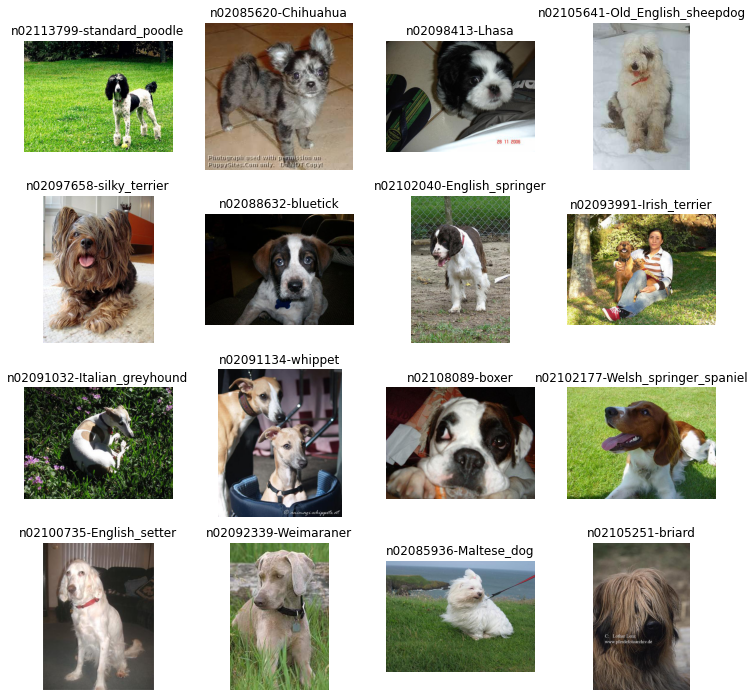

In [11]:
print_random_images()

* Let's print some random images 

In [6]:
datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


### Conclusion 

* We have 133 categories
* There are 6680 images in training set
* There are 863 images in validation set
* All categories:

In [7]:
train_generator.class_indices

{'n02085620-Chihuahua': 0,
 'n02085782-Japanese_spaniel': 1,
 'n02085936-Maltese_dog': 2,
 'n02086079-Pekinese': 3,
 'n02086240-Shih-Tzu': 4,
 'n02086646-Blenheim_spaniel': 5,
 'n02086910-papillon': 6,
 'n02087046-toy_terrier': 7,
 'n02087394-Rhodesian_ridgeback': 8,
 'n02088094-Afghan_hound': 9,
 'n02088238-basset': 10,
 'n02088364-beagle': 11,
 'n02088466-bloodhound': 12,
 'n02088632-bluetick': 13,
 'n02089078-black-and-tan_coonhound': 14,
 'n02089867-Walker_hound': 15,
 'n02089973-English_foxhound': 16,
 'n02090379-redbone': 17,
 'n02090622-borzoi': 18,
 'n02090721-Irish_wolfhound': 19,
 'n02091032-Italian_greyhound': 20,
 'n02091134-whippet': 21,
 'n02091244-Ibizan_hound': 22,
 'n02091467-Norwegian_elkhound': 23,
 'n02091635-otterhound': 24,
 'n02091831-Saluki': 25,
 'n02092002-Scottish_deerhound': 26,
 'n02092339-Weimaraner': 27,
 'n02093256-Staffordshire_bullterrier': 28,
 'n02093428-American_Staffordshire_terrier': 29,
 'n02093647-Bedlington_terrier': 30,
 'n02093754-Border_terr

* Deep learning algorithms are extremly are data hungry. The more data you have the better the algorithm will learn the differences. The amount of data we have for this classification task is not good enough. Simple convolutional networks will start to overfit the data by learning patterns in it instead of generalizing. Hence the model will be biased towards the training data.
<br><br>
* One of the main reason for this to happen is because our dataset is too small to find differences between 133 different breeds of dogs. Also there's a lot of noise in the dataet as you can see some images have more than one dog or some images also have human faces in them.
<br><br>
* As we know that the model is trained by maximizing it's accuracy on training dataset but it's performance is determined on its ability to perform well on unknown data.
<br><br>
*  In this situation our model just trying to memorize the training data as instead of trying to generalize from patterns observed in the training data.
<br><br>
* So to solve this problem we need more data, collecting which could take a lot of time. Another approach we can take is implement transfer learning where I will use some other state of the art CNN that has been  pre-trained on a big dataset.

## Part 3 ~> `Transfer Learning - Xception Network`

Transfer learning make use of the knowledge gained while solving one problem and applying it to a different but related problem.
For example, knowledge gained while learning to recognize cars can be used to some extent to recognize trucks.

I'm going to use Xception network which is trained on imagenet(a large dataset consisting about 14 million images).
Xception network is a very deep convolutional neural network which is over 71 layers deep with 21 million parameters.

In [ ]:
# Creating the Xception model
base_model = DenseNet121(weights='imagenet', include_top=False)

# freezing all the layers of Xception model by making them non trainable
for layer in base_model.layers:
    layer.trainable = False

# ADDING OUR NETWORK INCLUDING OUTPUT LAYER ON TOP

# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
# x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)

# and a logistic layer -- let's say we have NUM_CLASSES classes
predictions = Dense(133, activation='softmax')(x)

# this is the model we will train
model = keras.Model(inputs=base_model.input, outputs=predictions)

model.summary()

In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit_generator(
  train_generator,
  validation_data=test_generator,
  epochs=10,
  steps_per_epoch=len(train_generator),
  validation_steps=len(test_generator)
)

In [ ]:
plot_loss(history)

In [ ]:
plot_accuracy(history)

In [ ]:
model.save('densenet121_model.h5')

### Now let's print some images and their classified labels to see how well the algorithm did

In [ ]:
model = keras.model.load_model('densenet121_model.h5')